In [8]:
import numpy as np
import pandas as pd
from spec_id import Likelihood_contours, Median_w_Error,Median_w_Error_cont, Gen_spec, Analyze_LH_lwa, Gen_grid, Iterative_stacking
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,Zx_lwa,Zx_-_sig_lwa,Zx_+_sig_lwa,Z_lwa,Z_-_sig_lwa,Z_+_sig_lwa,t_lwa,t_-_sig_lwa,t_+_sig_lwa,A_v
43,n14713,14713,189.236333,62.214608,1.232,10.56,8.78,0.018,0.011,0.008,...,0.015916,0.010156,0.009539,0.016,0.010,0.009,2.6,0.656,0.479,0.0
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.020124,0.001403,0.002918,0.021,0.002,0.002,5.3,0.579,0.226,0.6
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.010305,0.002581,0.004545,0.011,0.003,0.004,2.4,0.478,0.580,0.3
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,0.013952,0.008305,0.010549,0.014,0.008,0.011,2.7,0.811,1.063,0.1
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.019900,0.004545,0.004208,0.020,0.005,0.004,2.2,0.432,0.405,0.6
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.017880,0.008641,0.008305,0.018,0.009,0.008,2.4,0.632,0.547,0.5
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.014064,0.006172,0.009034,0.015,0.007,0.008,3.4,0.762,0.847,0.4
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.019563,0.007743,0.006902,0.020,0.008,0.006,2.1,0.696,0.472,0.2
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.014345,0.004882,0.005667,0.015,0.006,0.005,2.8,0.459,0.963,0.0
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.015355,0.002357,0.004265,0.016,0.003,0.004,3.4,0.486,0.517,0.2


In [3]:
% matplotlib inline
for i in galDB.index:
    
    P,PZ,Pt = Analyze_LH_lwa('../chidat/%s_dtau_dust_chidata.npy' % galDB['gids'][i],
                             galDB['hi_res_specz'][i],metal,age,tau)

    np.save('../chidat/%s_dtau_tZ_pos_lwa_dust.npy' % galDB['gids'][i],P)  
    np.save('../chidat/%s_dtau_Z_pos_lwa_dust.npy' % galDB['gids'][i],[metal,PZ]) 
    np.save('../chidat/%s_dtau_t_pos_lwa_dust.npy' % galDB['gids'][i],[age,Pt])
        
#     onesig,twosig = Likelihood_contours(age,metal,P)
#     levels = np.array([twosig,onesig])
#     ###PLOT
#     gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
#     plt.figure(figsize=[8,8])
#     plt.subplot(gs[2])
#     plt.contour(M,A,P,levels,colors='k',linewidths=2)
#     plt.contourf(M,A,P,40,cmap=cmap)
#     plt.axis([0,0.03,0,6])
#     plt.xlabel('Metallicity (Z$_\odot$)',size=35)
#     plt.ylabel('Average Age (Gyrs)',size=35)
#     plt.tick_params(axis='both', which='major', labelsize=25)
#     plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
#     plt.subplot(gs[0])
#     plt.plot(metal,PZ)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlim(0,0.03)
#     plt.ylim(0,max(PZ))
#     plt.subplot(gs[3])
#     plt.plot(Pt,age)
#     plt.xticks([])
#     plt.yticks([])
#     plt.ylim(0,6)
#     plt.xlim(0,max(Pt))
#     plt.savefig('../plots/LHS/%s_lh_lwa3.png' % galDB['gids'][i])
#     plt.close()

In [35]:
med = np.zeros(len(galDB.index))
lerr = np.zeros(len(galDB.index))
herr = np.zeros(len(galDB.index))


for i in range(len(galDB.index)):
    t, Pt = np.load('../chidat/%s_t_pos.npy' % galDB['gids'][galDB.index[i]])
    med[i],lerr[i],herr[i] = Median_w_Error(Pt,t)

In [46]:
galDB['t_+_sig'] = herr

In [48]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig
43,n14713,14713,189.236333,62.214608,1.232,0.019,0.012,0.008,3.1,0.903,0.541
49,n16758,16758,189.162357,62.224840,1.014,0.021,0.002,0.002,5.5,0.470,0.125
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.010,0.010,2.9,1.033,0.818
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622
62,n21427,21427,189.368121,62.247344,1.514,0.020,0.009,0.007,2.8,0.779,0.533
69,n23435,23435,189.338306,62.256571,1.134,0.015,0.007,0.008,3.7,0.907,0.779
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.007,2.7,1.054,0.919
96,n34694,34694,189.147840,62.323647,1.145,0.014,0.005,0.006,3.1,0.671,1.048
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548


In [12]:
# pd.to_pickle(galDB,'../data/sgal_param_DB.pkl')

In [11]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

In [13]:
mzDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig,lmass,tau
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998,10.92,8.60
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622,11.16,8.30
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548,10.89,8.60
212,s35774,35774,53.158775,-27.742385,1.223,0.009,0.004,0.011,3.5,1.446,0.803,10.86,8.60
217,s38785,38785,53.168249,-27.727300,1.175,0.014,0.009,0.008,3.3,1.081,0.738,10.88,8.78
225,s39805,39805,53.163237,-27.724724,1.242,0.022,0.011,0.006,2.9,0.967,0.554,10.62,8.78
228,s40476,40476,53.108262,-27.721924,1.212,0.007,0.003,0.006,2.9,0.769,0.675,10.59,8.60
230,s40597,40597,53.148451,-27.719472,1.221,0.026,0.006,0.003,3.6,0.477,0.174,11.01,8.90


In [10]:
meds = []
mlerr = []
mherr = []
for i in galDB.index:
    Z,PZ = np.load('../chidat/%s_dtau_t_pos_lwa_dust.npy' % galDB['gids'][i])
    mds,ml,mh = Median_w_Error(PZ,Z)
    meds.append(mds)
    mlerr.append(ml)
    mherr.append(mh)

In [11]:
galDB['t_cal']=meds
galDB['t_-_sig_cal']=mlerr
galDB['t_+_sig_cal']=mherr

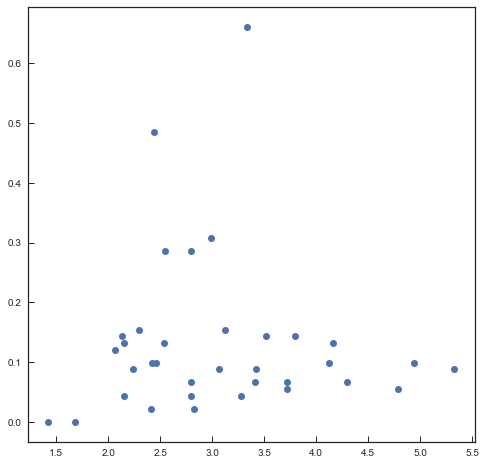

In [12]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(galDB['tx_dt'],galDB['tx_dt'] - galDB['tx_lwa'],'o')

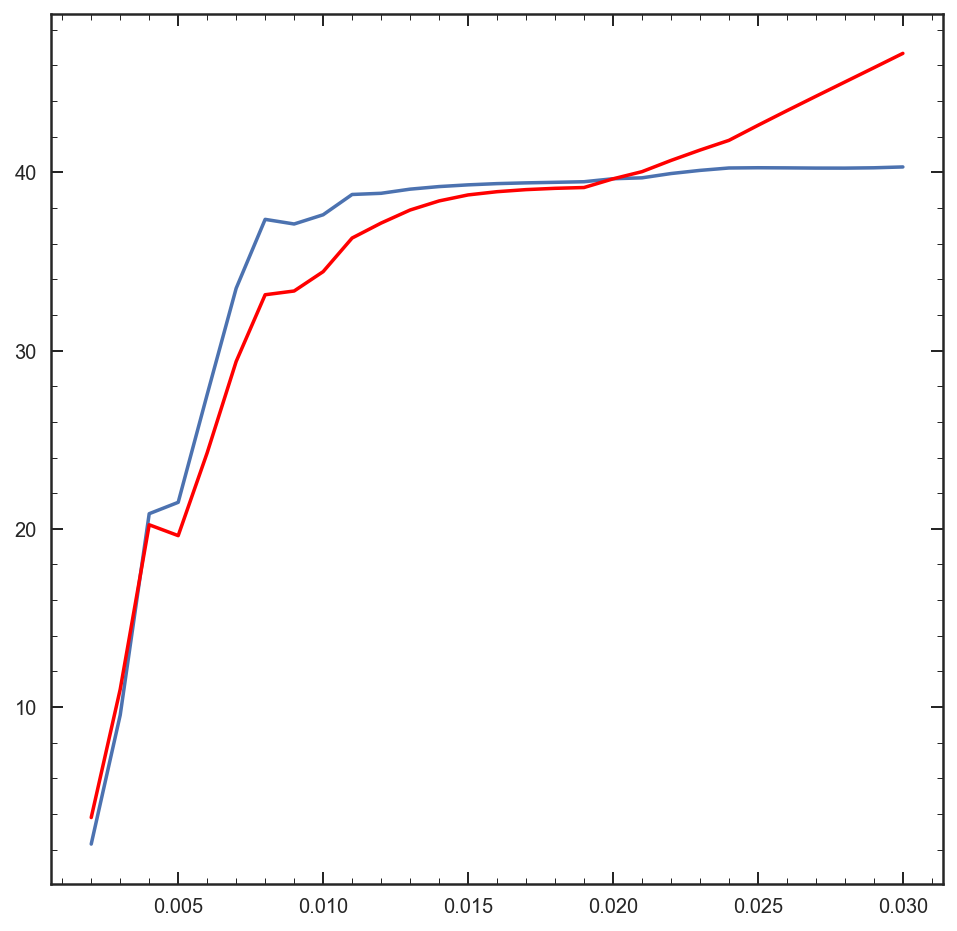

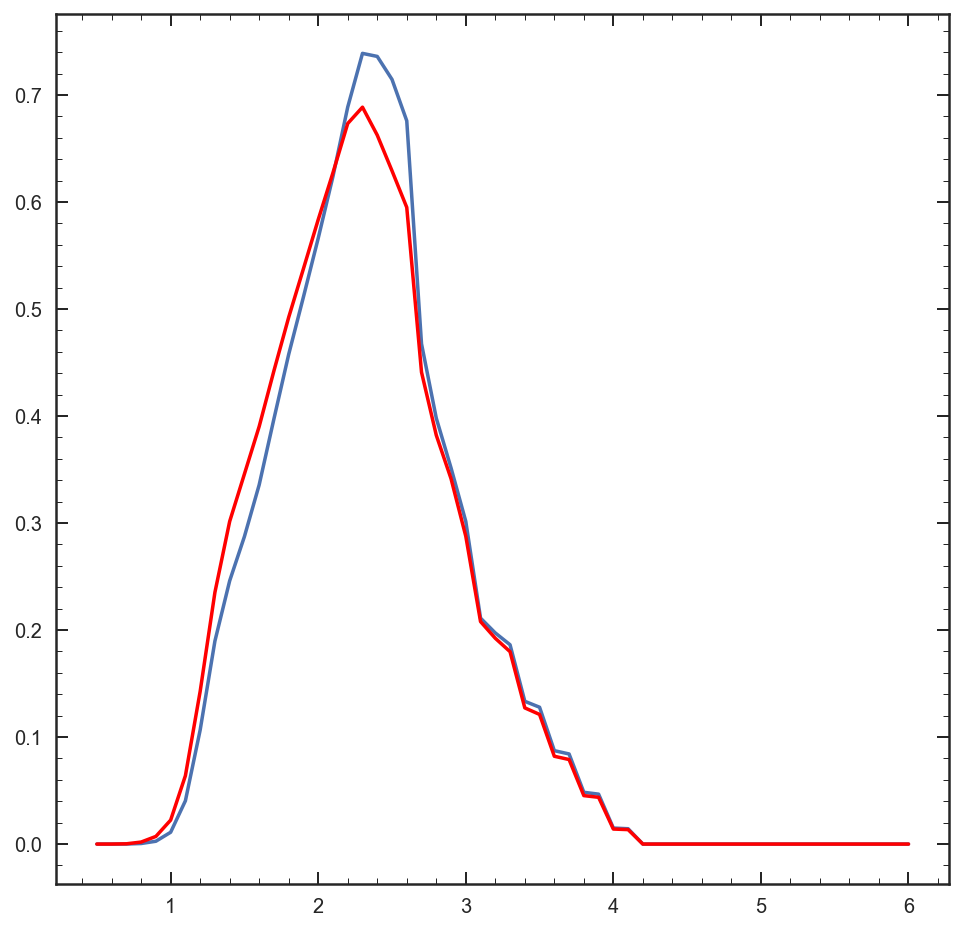

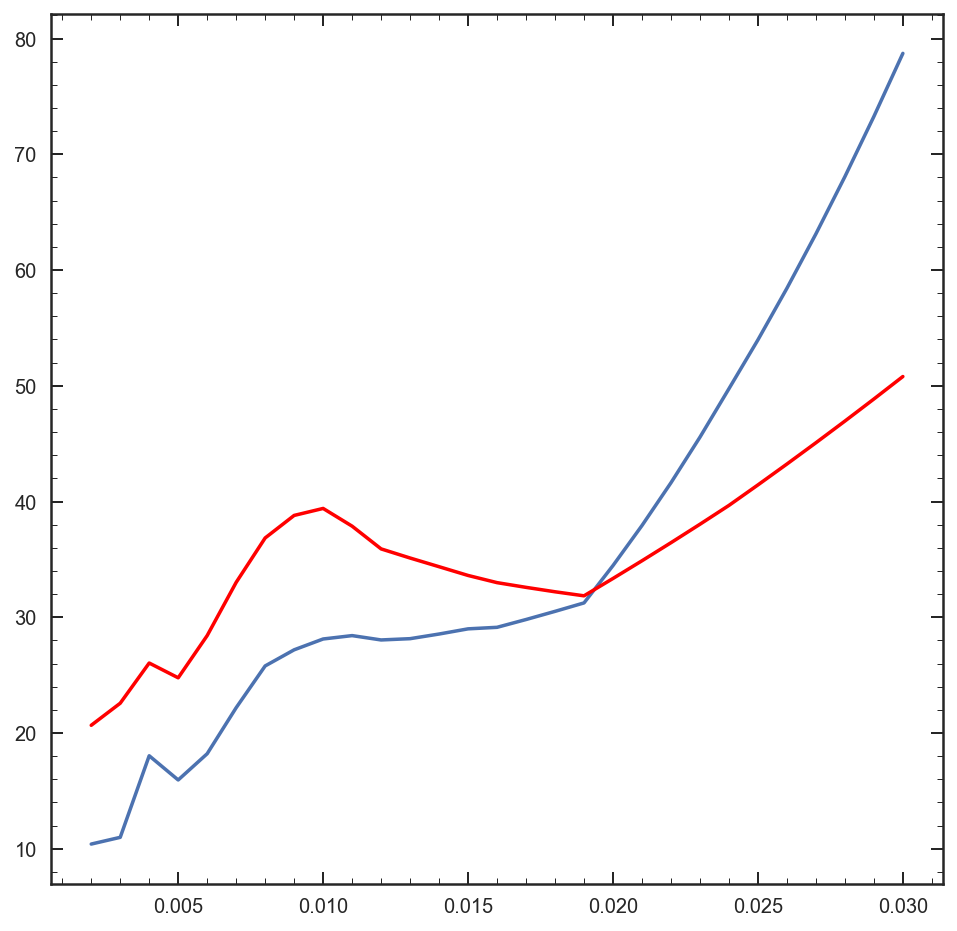

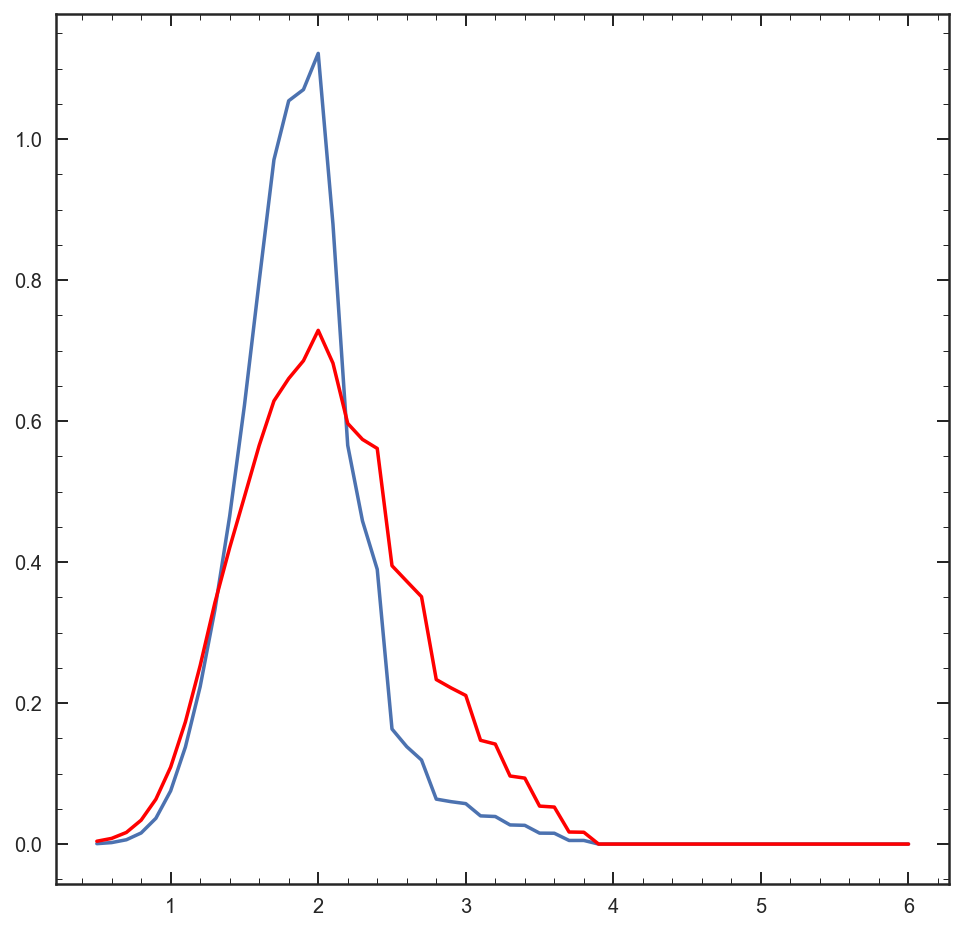

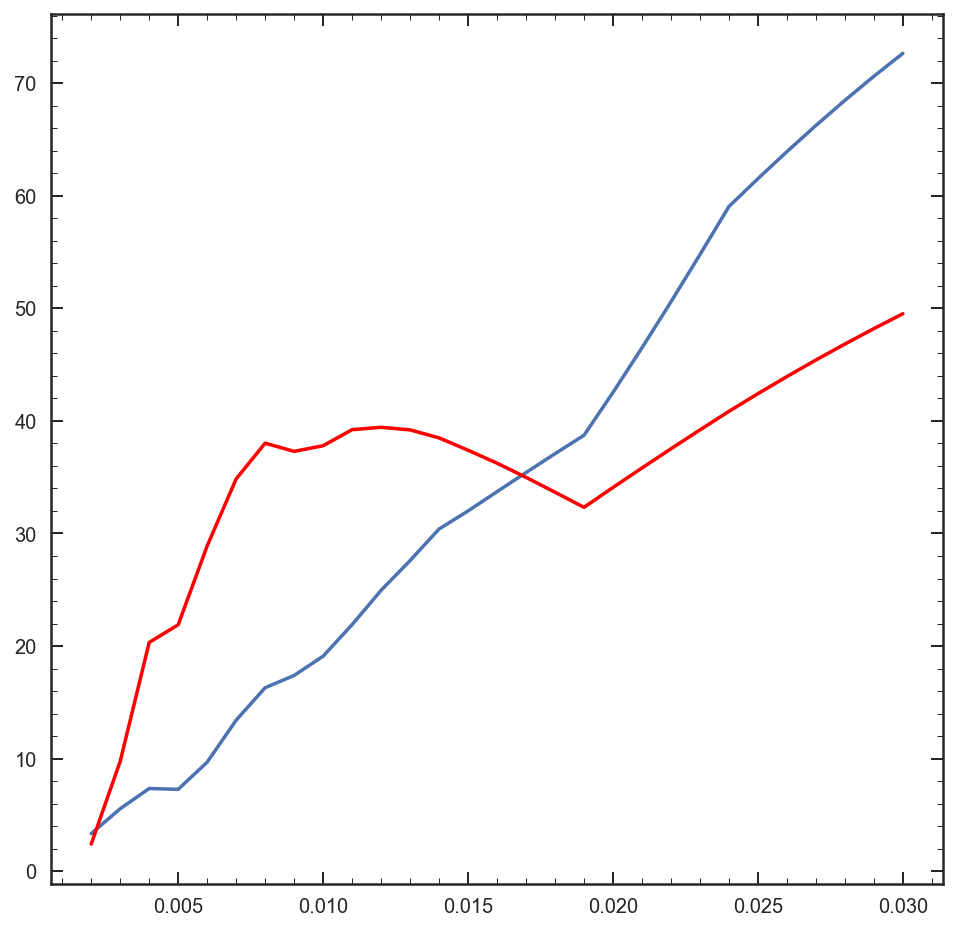

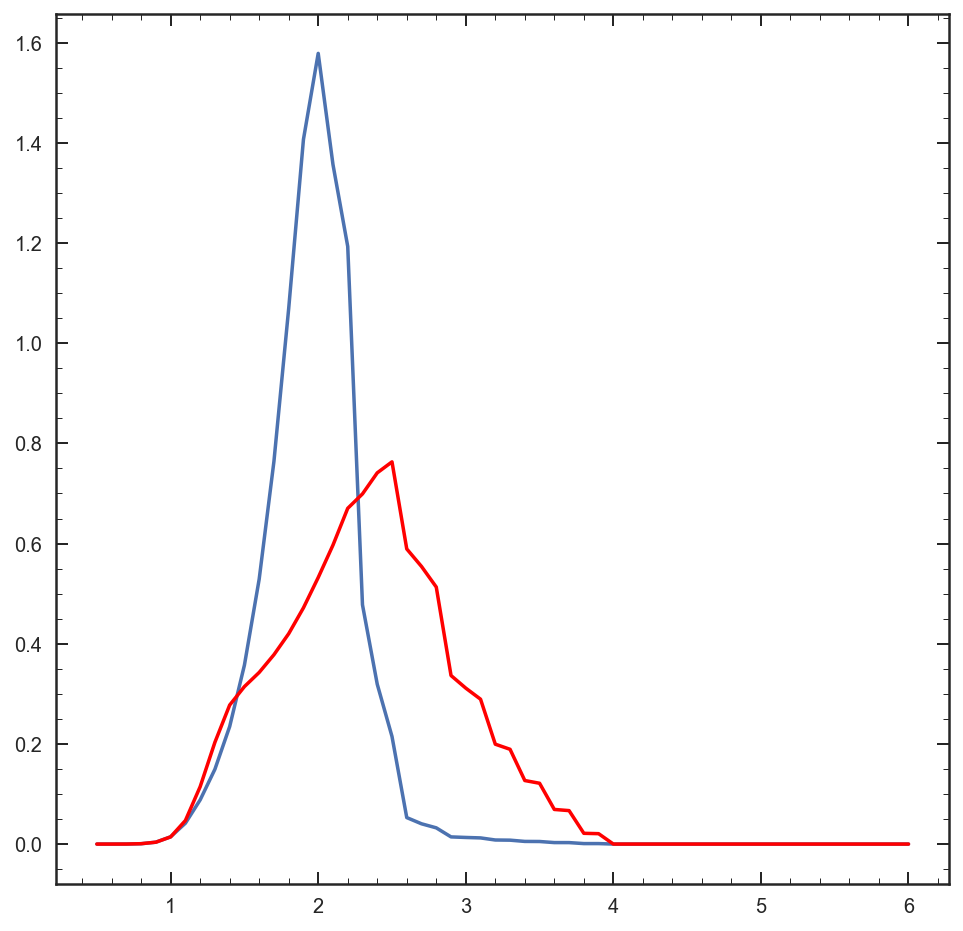

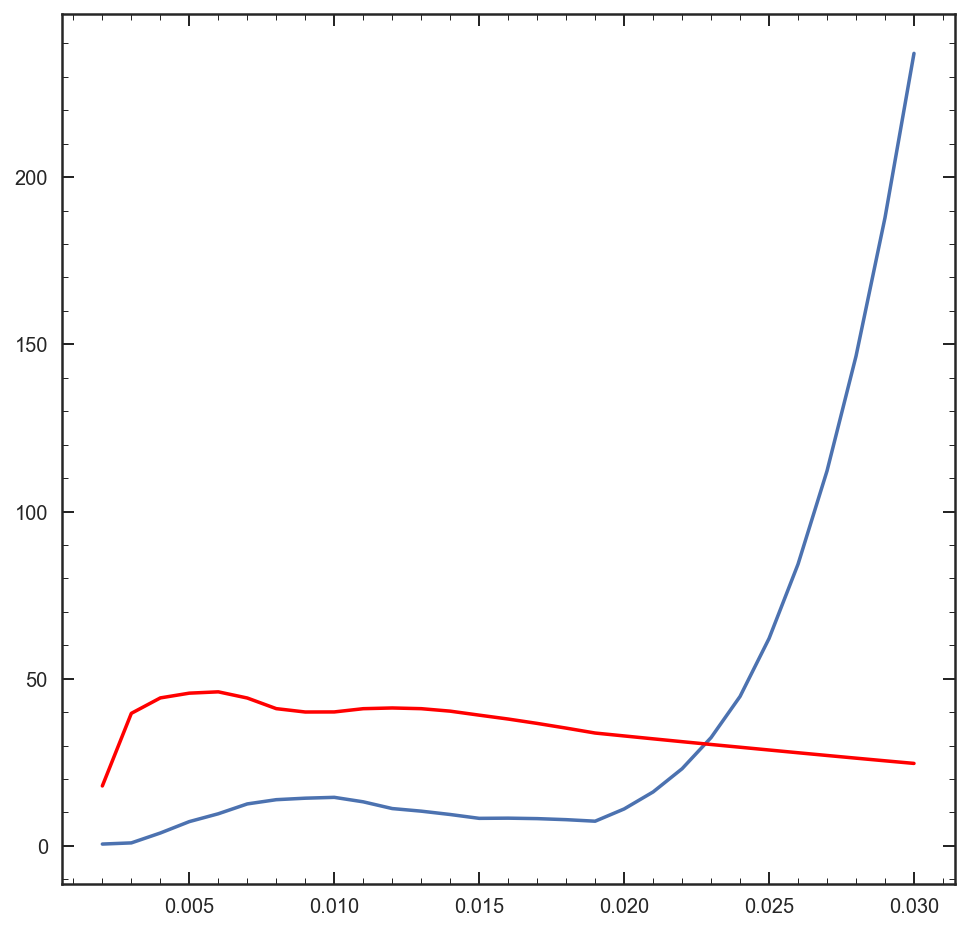

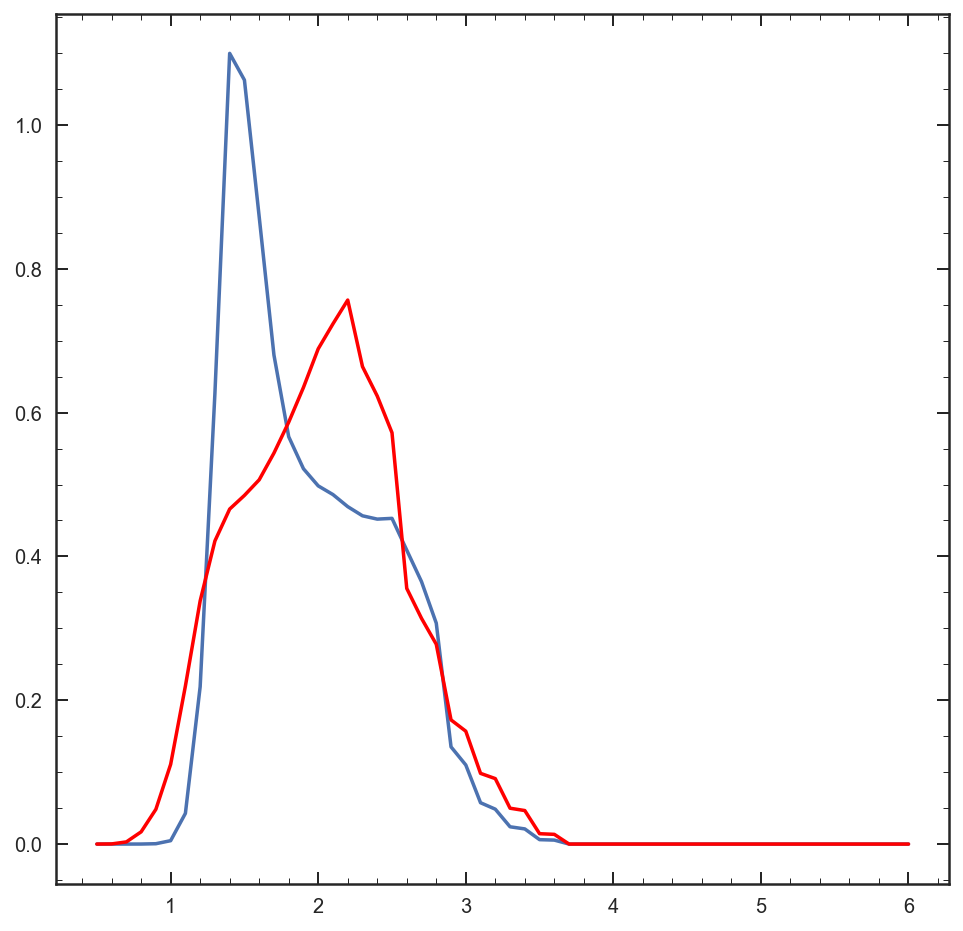

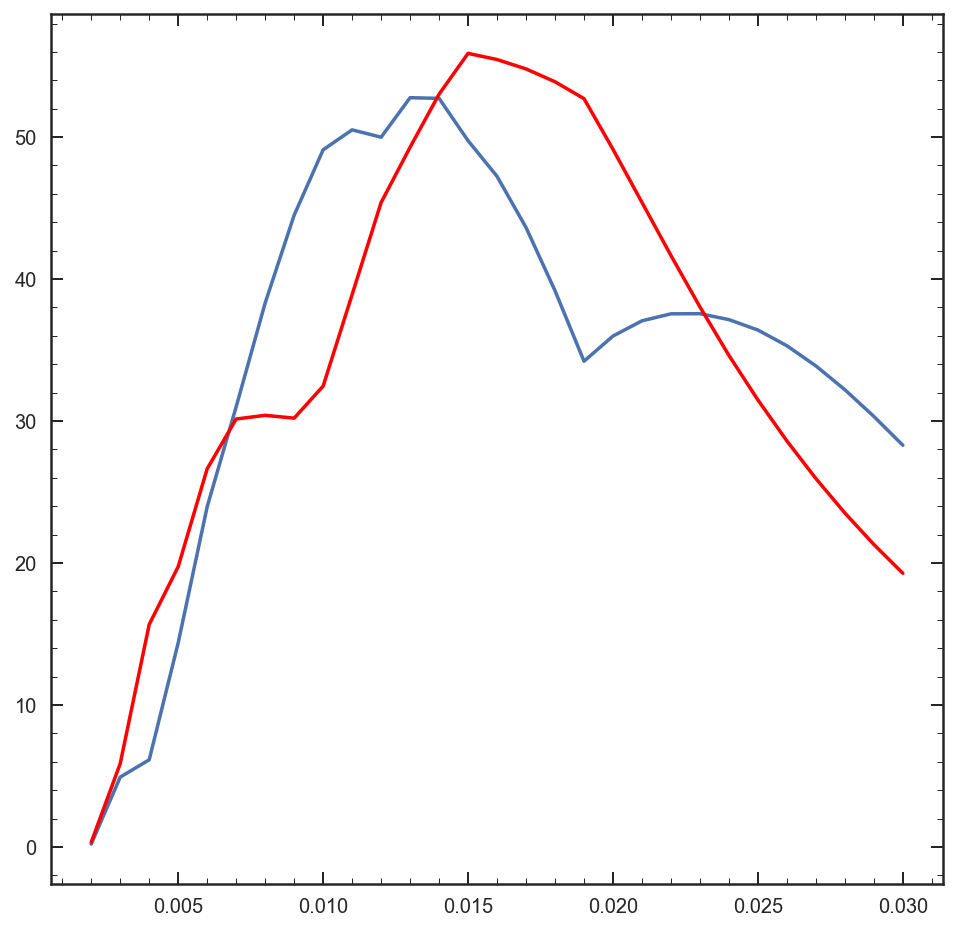

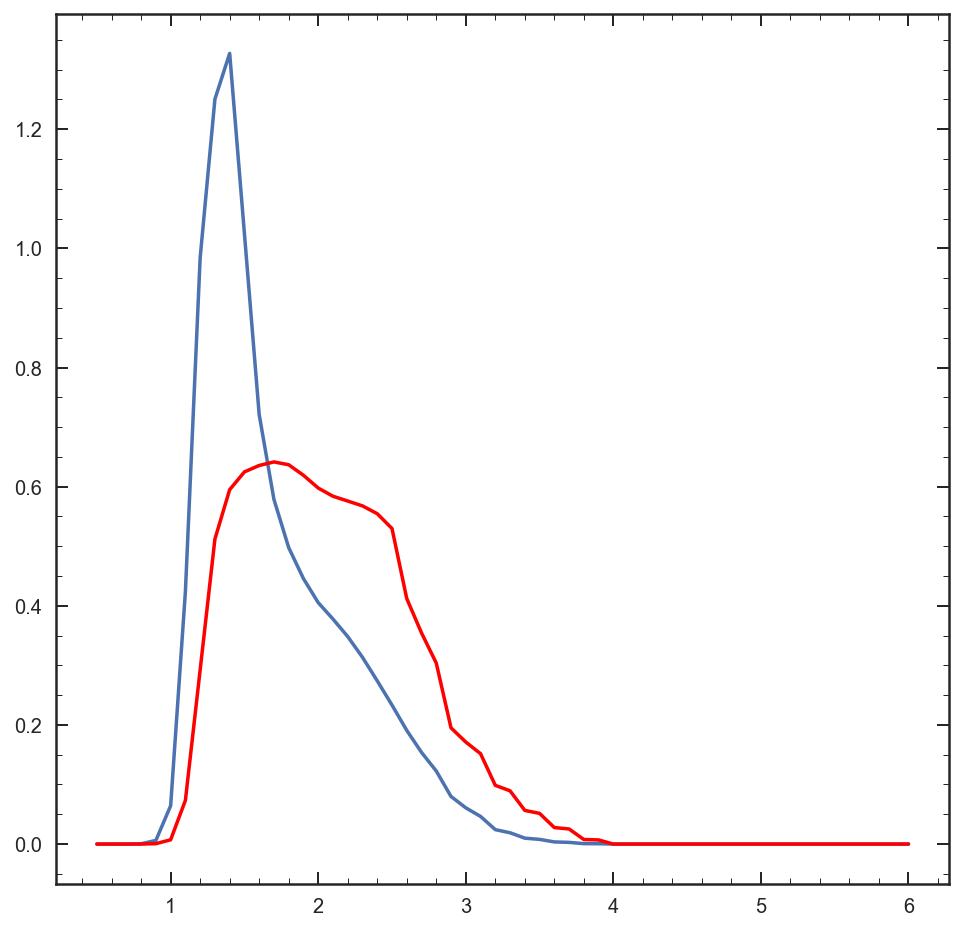

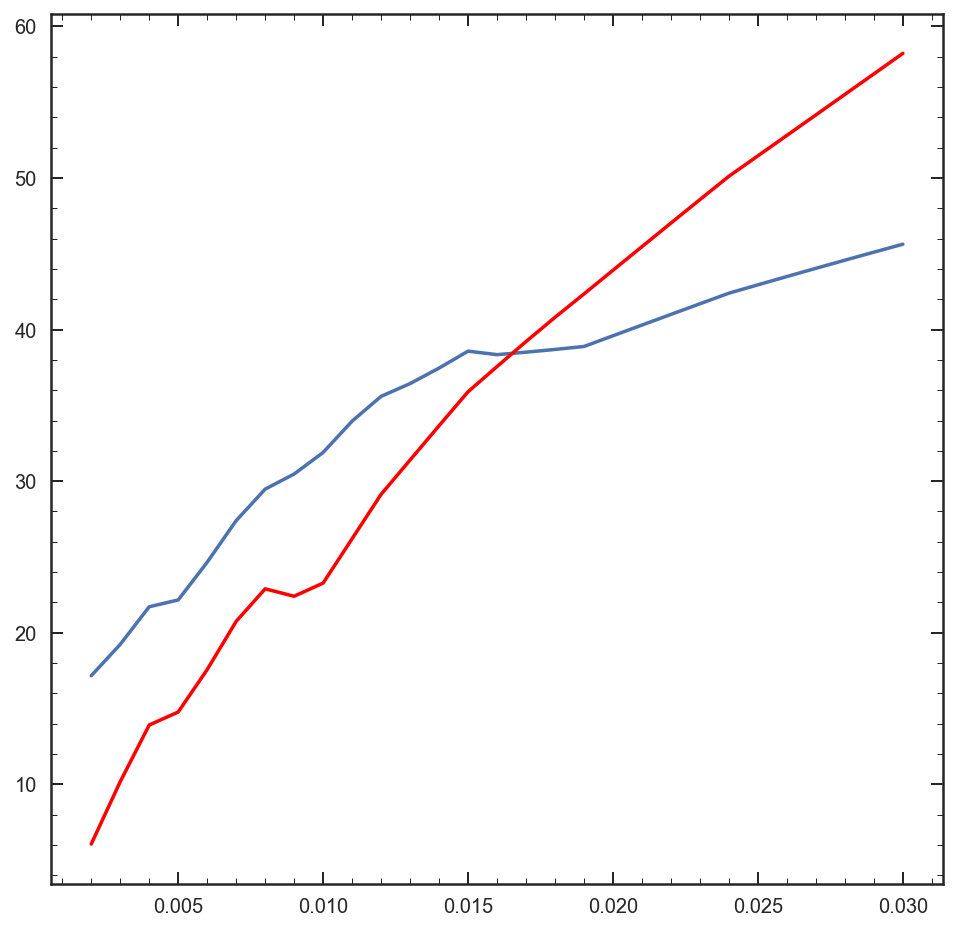

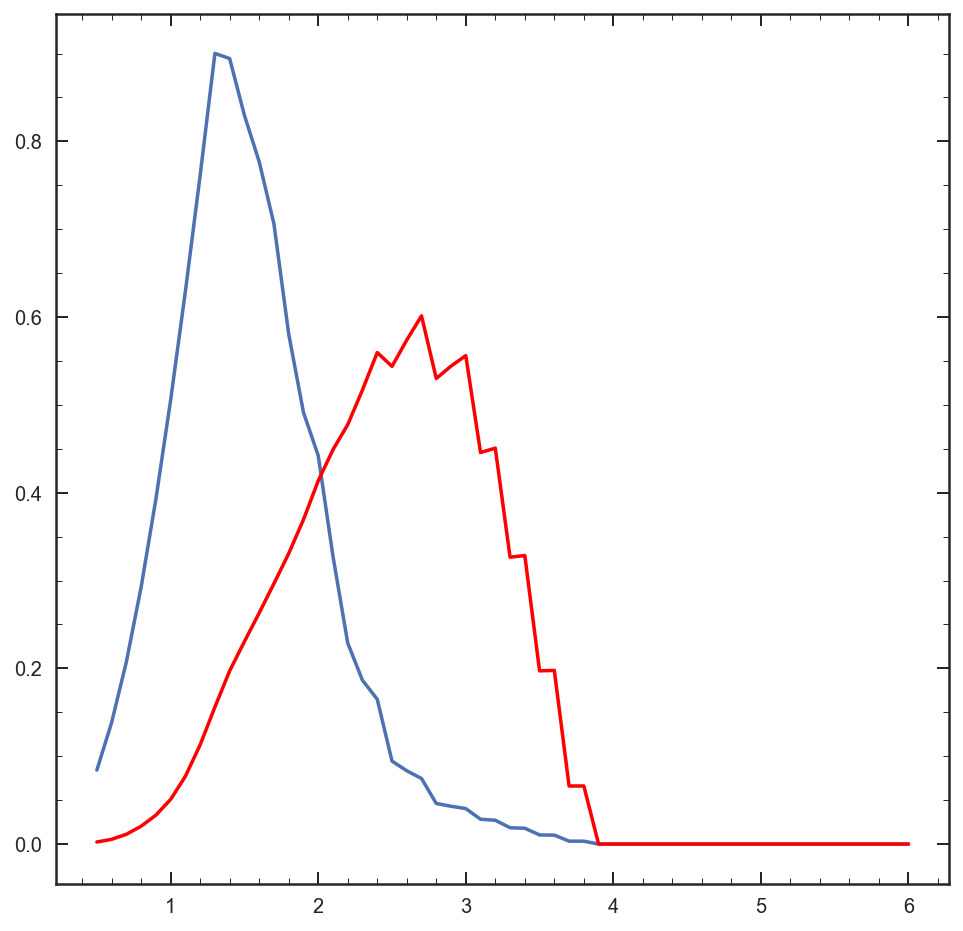

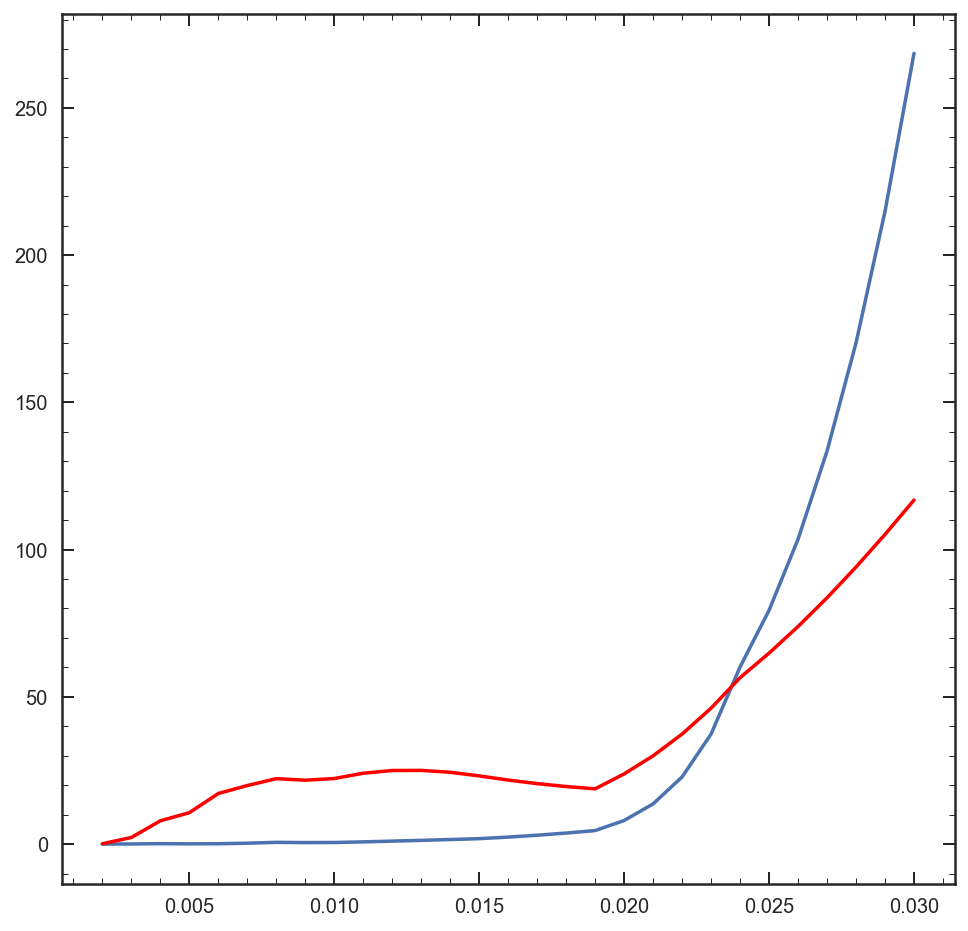

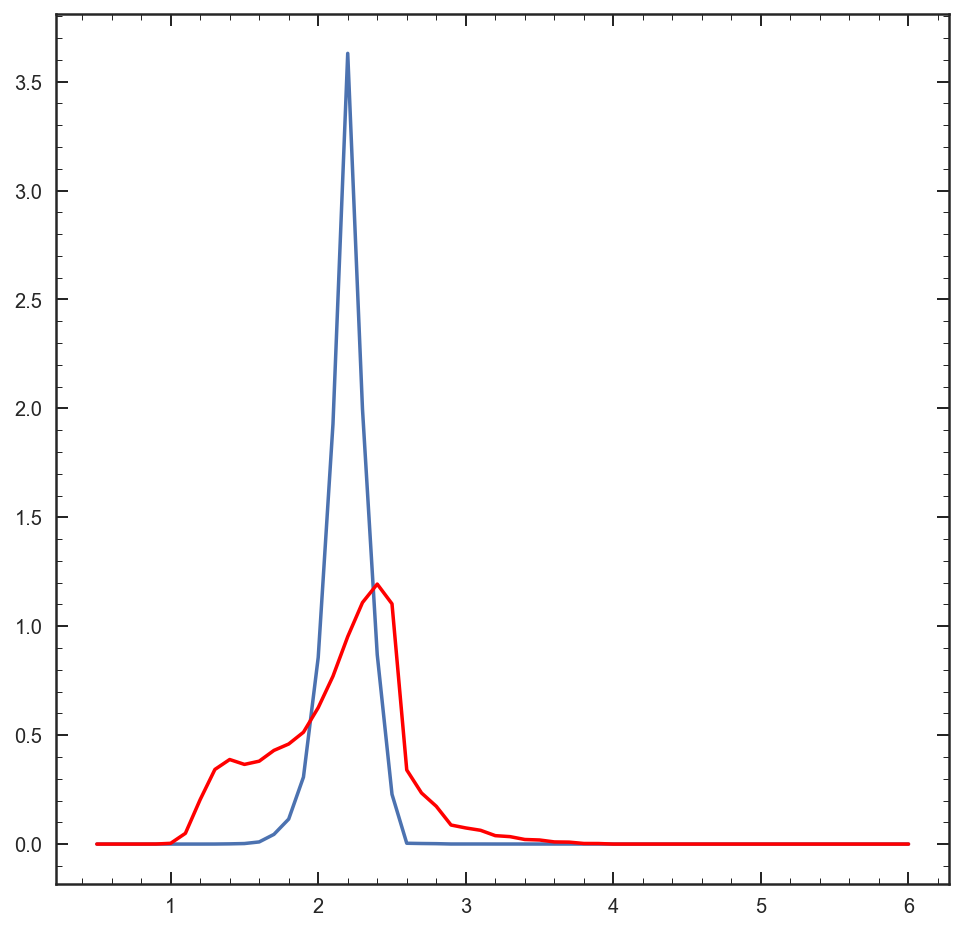

In [5]:
for i in uhzDB.index:
    Z1,PZ1 = np.load('../chidat/{0}_dtau_Z_pos_lwa_dust.npy'.format(uhzDB['gids'][i]))
    Z2,PZ2 = np.load('../chidat/{0}_gt_3900_Z_pos.npy'.format(uhzDB['gids'][i]))
    
    t1,Pt1 = np.load('../chidat/{0}_dtau_t_pos_lwa_dust.npy'.format(uhzDB['gids'][i]))
    t2,Pt2 = np.load('../chidat/{0}_gt_3900_t_pos.npy'.format(uhzDB['gids'][i]))
    
    plt.figure(figsize=[8,8])
    plt.plot(Z1,PZ1)
    plt.plot(Z2,PZ2,'r')   
    
    plt.figure(figsize=[8,8])
    plt.plot(t1,Pt1)
    plt.plot(t2,Pt2,'r') 

In [7]:
def Gen_grid_gt(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/{0}_gt_3900_{1}_pos.npy'.format(DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [9]:
PZ1_grid = Gen_grid(uhzDB,'Z')
PZ2_grid = Gen_grid_gt(uhzDB,'Z')
Pt1_grid = Gen_grid(uhzDB,'t')
Pt2_grid = Gen_grid_gt(uhzDB,'t')

iPZ1, iZ1 = Iterative_stacking(PZ1_grid,metal)
iPZ2, iZ2 = Iterative_stacking(PZ2_grid,metal)
iPt1, it1 = Iterative_stacking(Pt1_grid,age)
iPt2, it2 = Iterative_stacking(Pt2_grid,age)

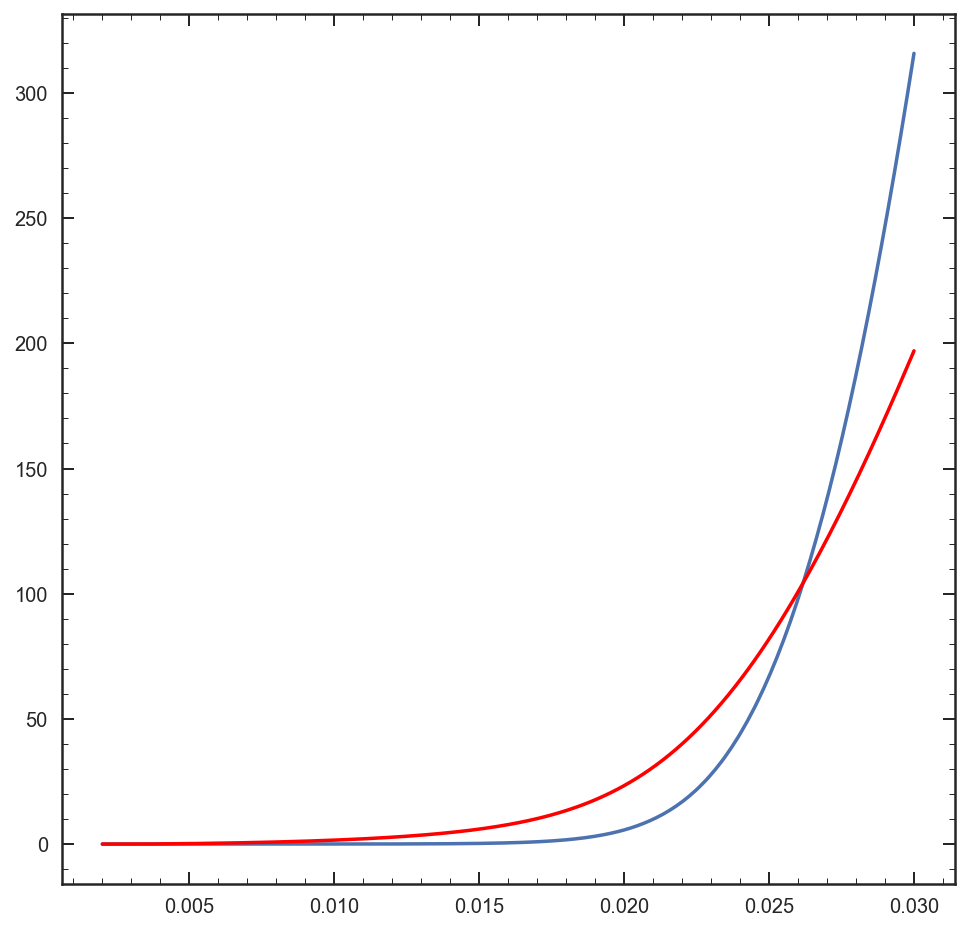

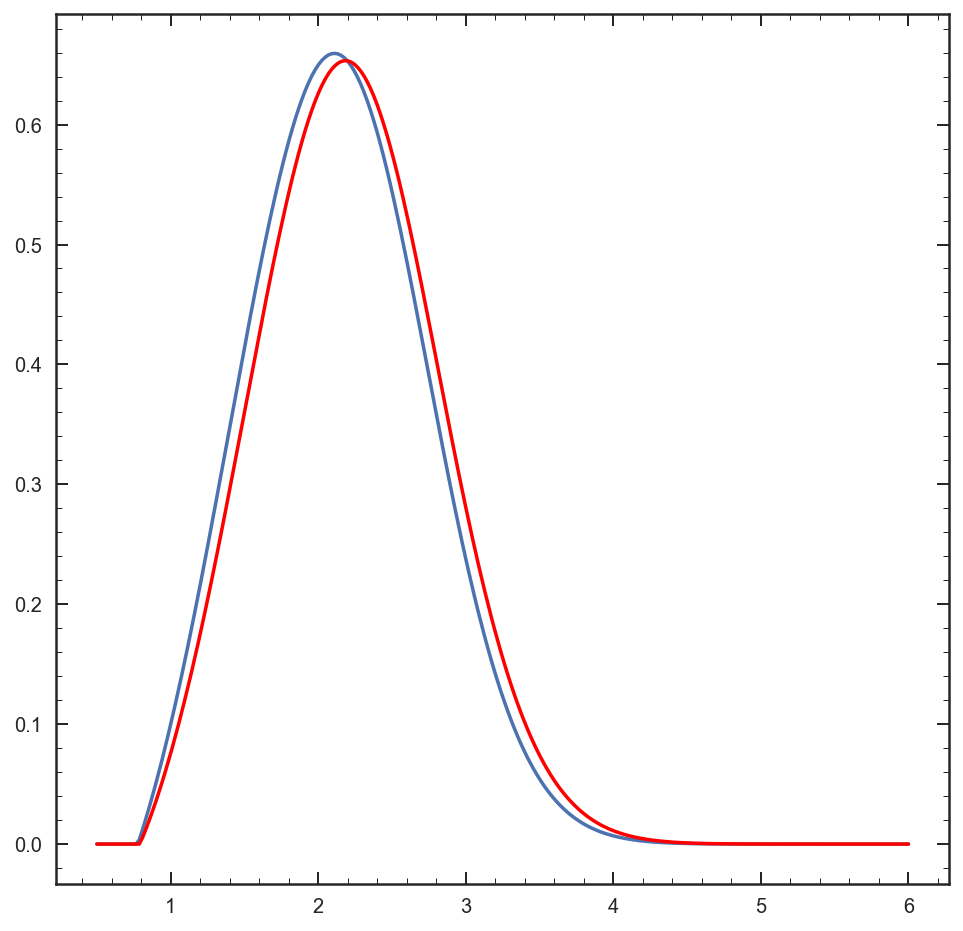

In [10]:
plt.figure(figsize=[8,8])
plt.plot(iZ1,iPZ1)
plt.plot(iZ2,iPZ2,'r')   

plt.figure(figsize=[8,8])
plt.plot(it1,iPt1)
plt.plot(it2,iPt2,'r') 

In [13]:
Zmed,Zlerr,Zherr = np.zeros([3,7])
tmed,tlerr,therr = np.zeros([3,7])

for i in range(len(uhzDB.index)):
    Z2,PZ2 = np.load('../chidat/{0}_gt_3900_Z_pos.npy'.format(uhzDB['gids'][uhzDB.index[i]]))
    t2,Pt2 = np.load('../chidat/{0}_gt_3900_t_pos.npy'.format(uhzDB['gids'][uhzDB.index[i]]))
    
    Zmed[i],Zlerr[i],Zherr[i] = Median_w_Error_cont(PZ2,Z2)
    tmed[i],tlerr[i],therr[i] = Median_w_Error_cont(Pt2,t2)

(0, 0.71862518712961976)

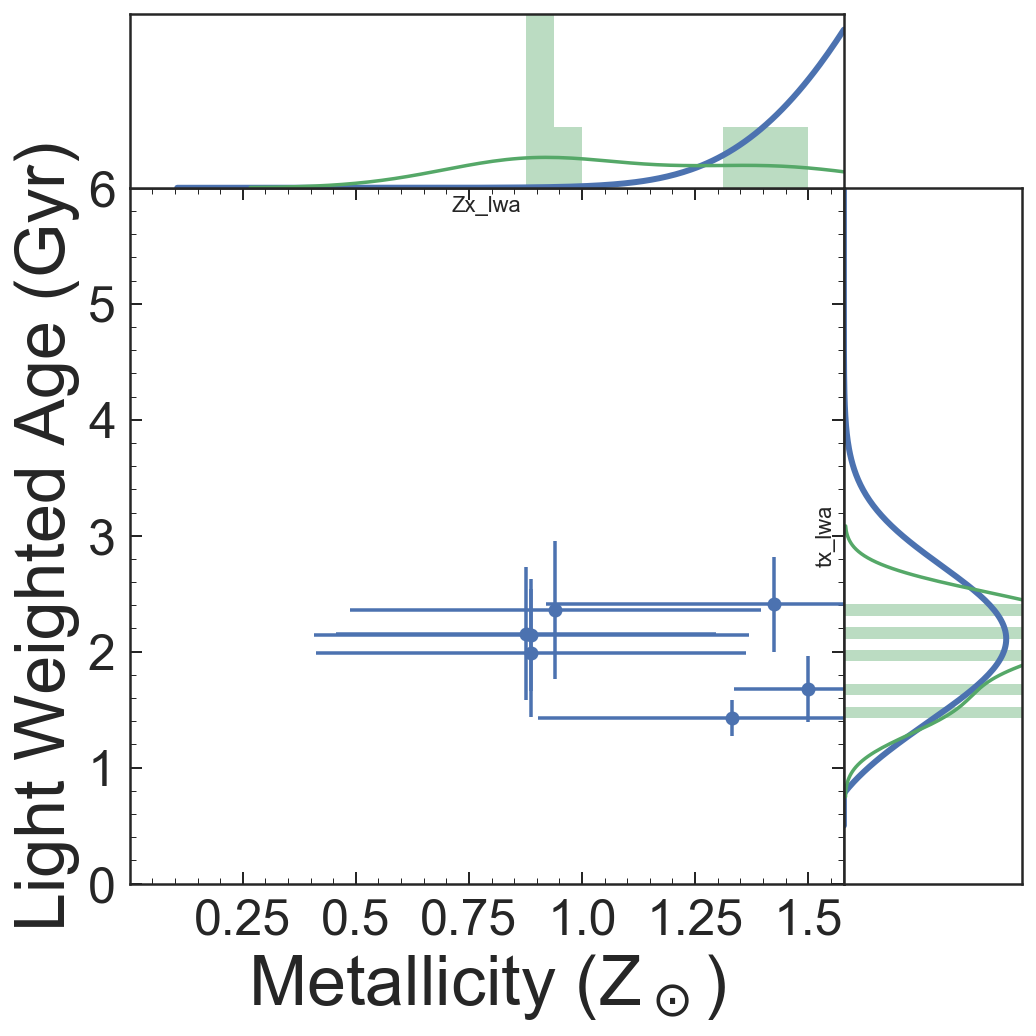

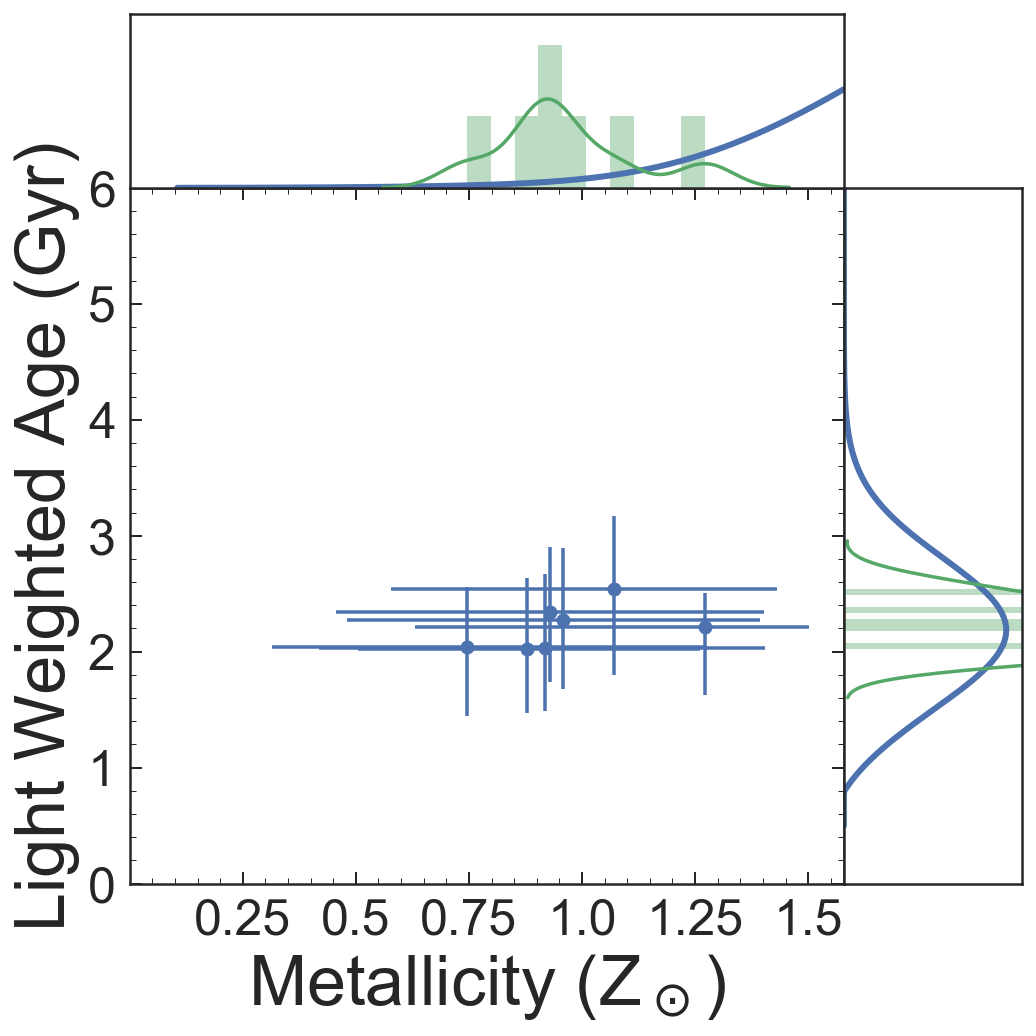

In [14]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.errorbar(uhzDB['Zx_lwa'],uhzDB['tx_lwa'],xerr=[uhzDB['Zx_-_sig_lwa'],uhzDB['Zx_-_sig_lwa']],yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_-_sig_lwa']],fmt='o')
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(iZ1,iPZ1,linewidth=3)
sea.distplot(uhzDB['Zx_lwa'],bins=10)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(iPZ1)*1.1)

plt.subplot(gs[3])
plt.plot(iPt1,it1,linewidth=3)
sea.distplot(uhzDB['tx_lwa'],bins=10,vertical=True)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(iPt1)*1.1)

#################################

gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.errorbar(Zmed,tmed,xerr=[Zlerr,Zherr],yerr=[tlerr,therr],fmt='o')
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(iZ2,iPZ2,linewidth=3)
sea.distplot(Zmed,bins=10)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(iPZ1)*1.1)

plt.subplot(gs[3])
plt.plot(iPt2,it2,linewidth=3)
sea.distplot(tmed,bins=10,vertical=True)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(iPt2)*1.1)

[0, 0.03, 0, 0.03]

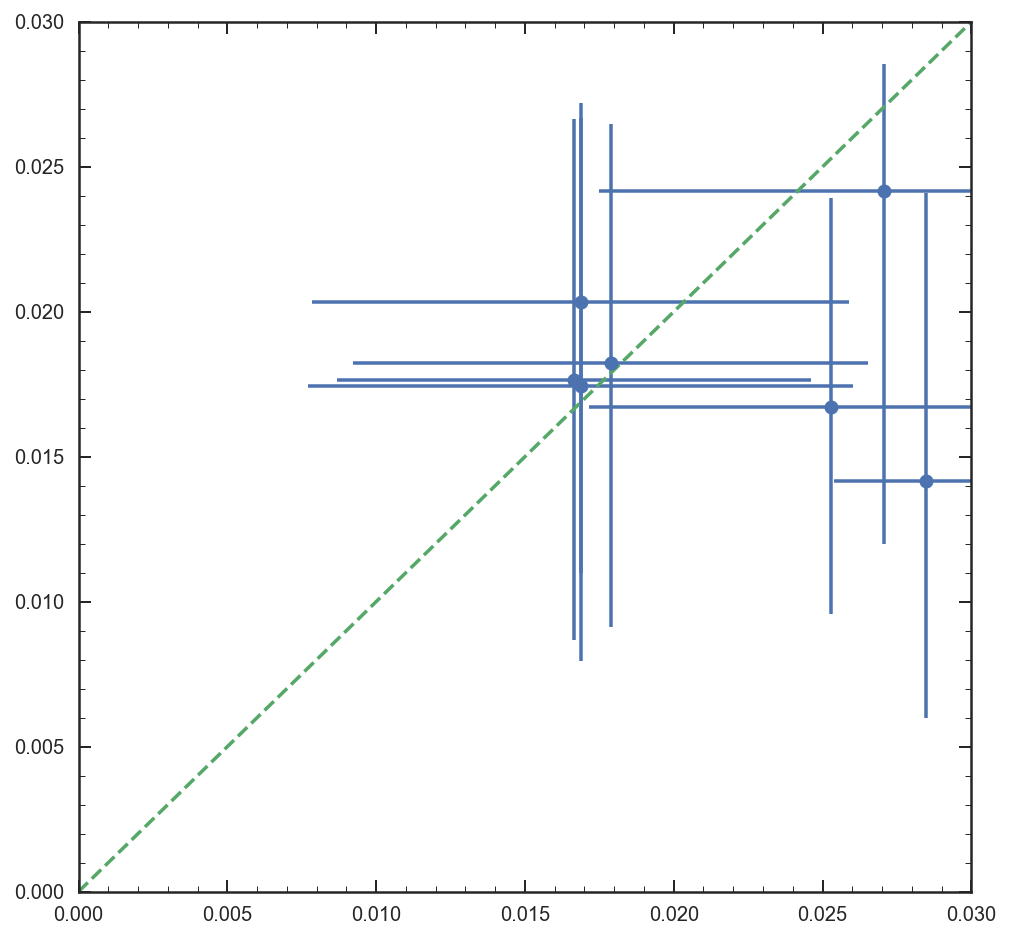

In [19]:
plt.figure(figsize=[8,8])
plt.errorbar(uhzDB['Zx_lwa'],Zmed,xerr=[uhzDB['Zx_-_sig_lwa'],uhzDB['Zx_-_sig_lwa']],yerr=[Zlerr,Zherr],fmt='o')
plt.plot([0,0.03],[0,0.03],'--')
plt.axis([0,0.03,0,0.03])

[0, 6, 0, 6]

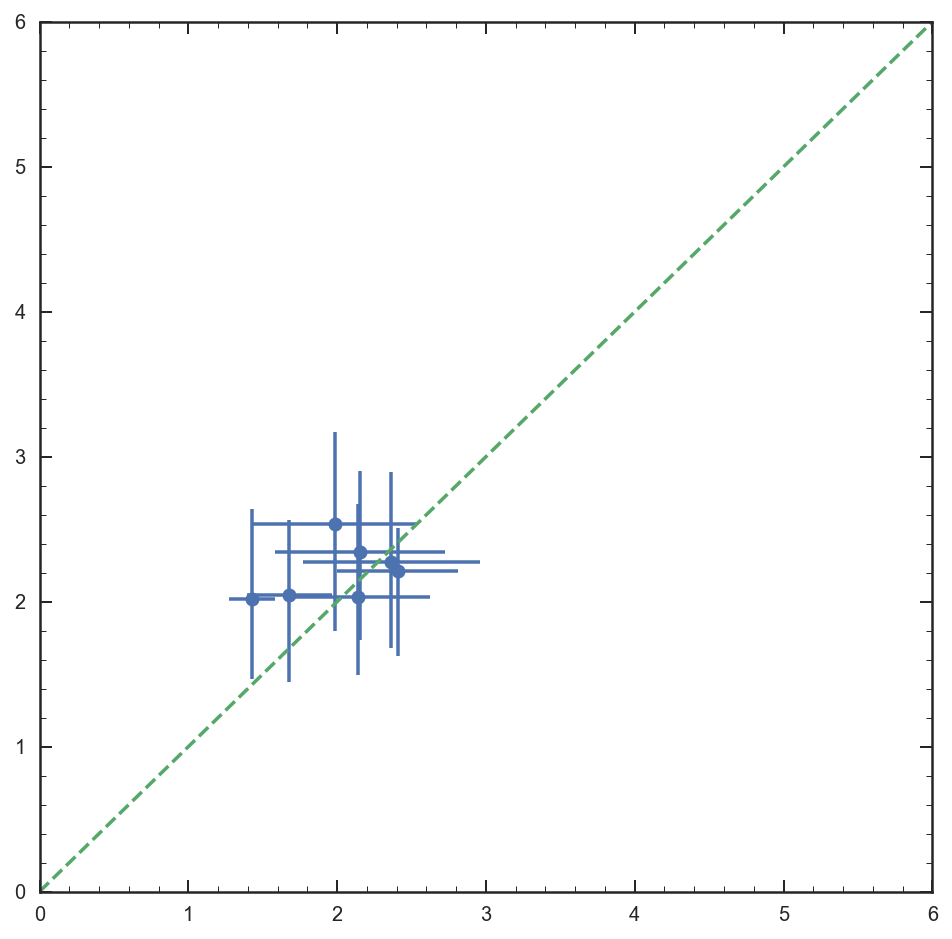

In [20]:
plt.figure(figsize=[8,8])
plt.errorbar(uhzDB['tx_lwa'],tmed,xerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_-_sig_lwa']],yerr=[tlerr,therr],fmt='o')
plt.plot([0,6],[0,6],'--')
plt.axis([0,6,0,6])

# No H$\beta$

In [30]:
###DATA
P = np.load('../chidat/n21156_dtau_tZ_pos_lwa_3.npy')
t,Pt = np.load('../chidat/n21156_dtau_t_pos_lwa_3.npy')
Z,PZ = np.load('../chidat/n21156_dtau_Z_pos_lwa_3.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

P2 = np.load('../chidat/n21156_no_Hb_tZ_pos.npy')
t,Pt2 = np.load('../chidat/n21156_no_Hb_t_pos.npy')
Z,PZ2 = np.load('../chidat/n21156_no_Hb_Z_pos.npy')
onesig,twosig = Likelihood_contours(age,metal,P2)
levels2 = np.array([twosig,onesig])                

(0, 1.4606902354545817384)

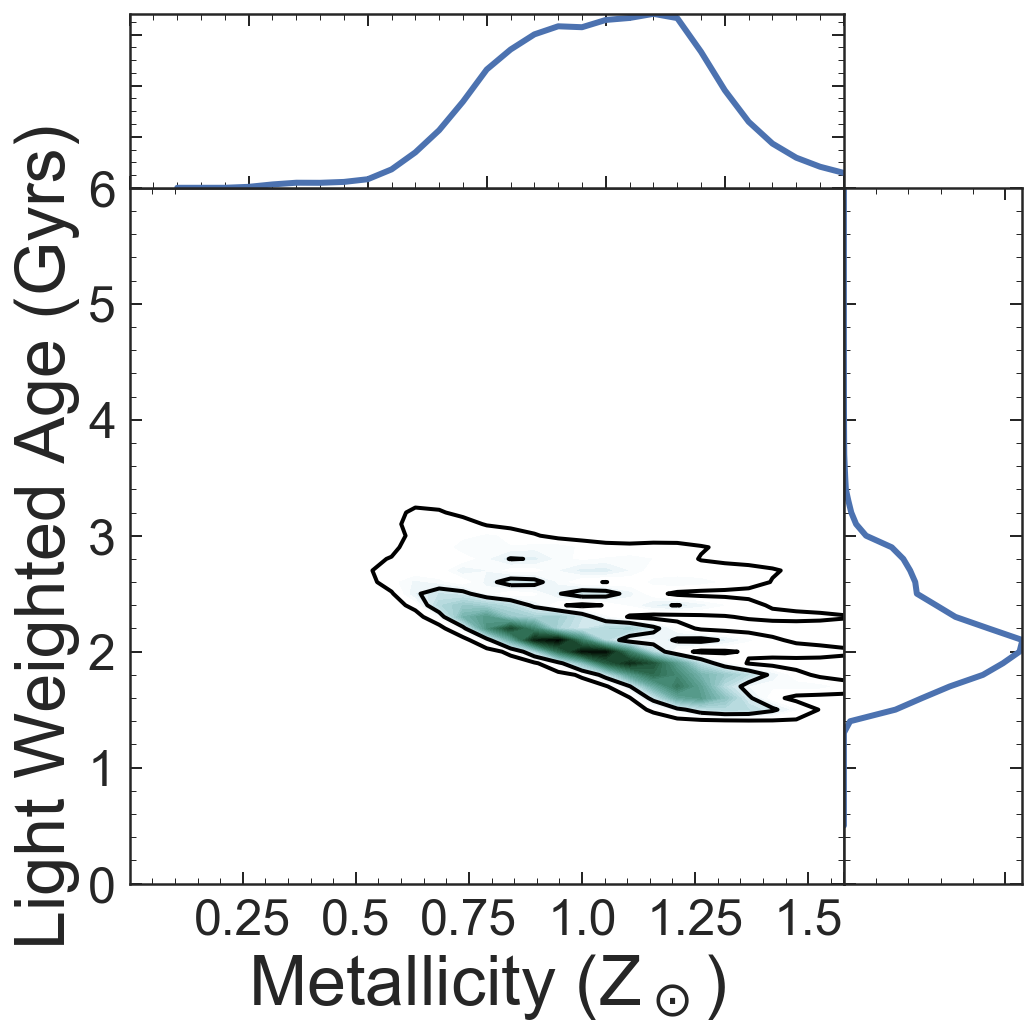

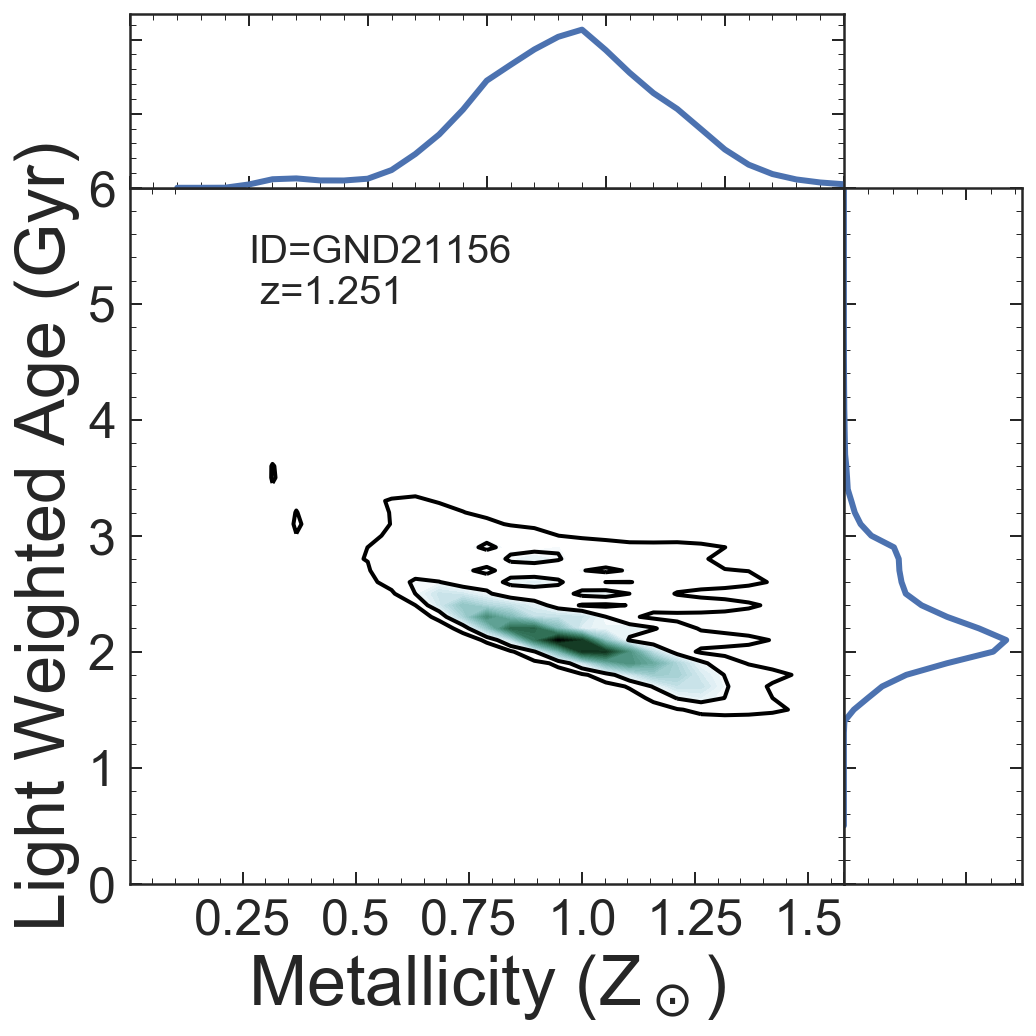

In [31]:
%matplotlib inline

###PLOT
gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyrs)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(Z,PZ,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.xlim(0,0.03)
plt.ylim(0,max(PZ))

plt.subplot(gs[3])
plt.plot(Pt,t,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylim(0,6)
plt.xlim(0,max(Pt))

gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P2,levels,colors='k',linewidths=2)
plt.contourf(M,A,P2,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.text(.005,5,'ID=GND21156\n z=1.251', fontsize=20)

plt.subplot(gs[0])
plt.plot(Z,PZ2,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.xlim(0,0.03)
plt.ylim(0,max(PZ2)*1.1)

plt.subplot(gs[3])
plt.plot(Pt2,t,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylim(0,6)
plt.xlim(0,max(Pt2)*1.1)


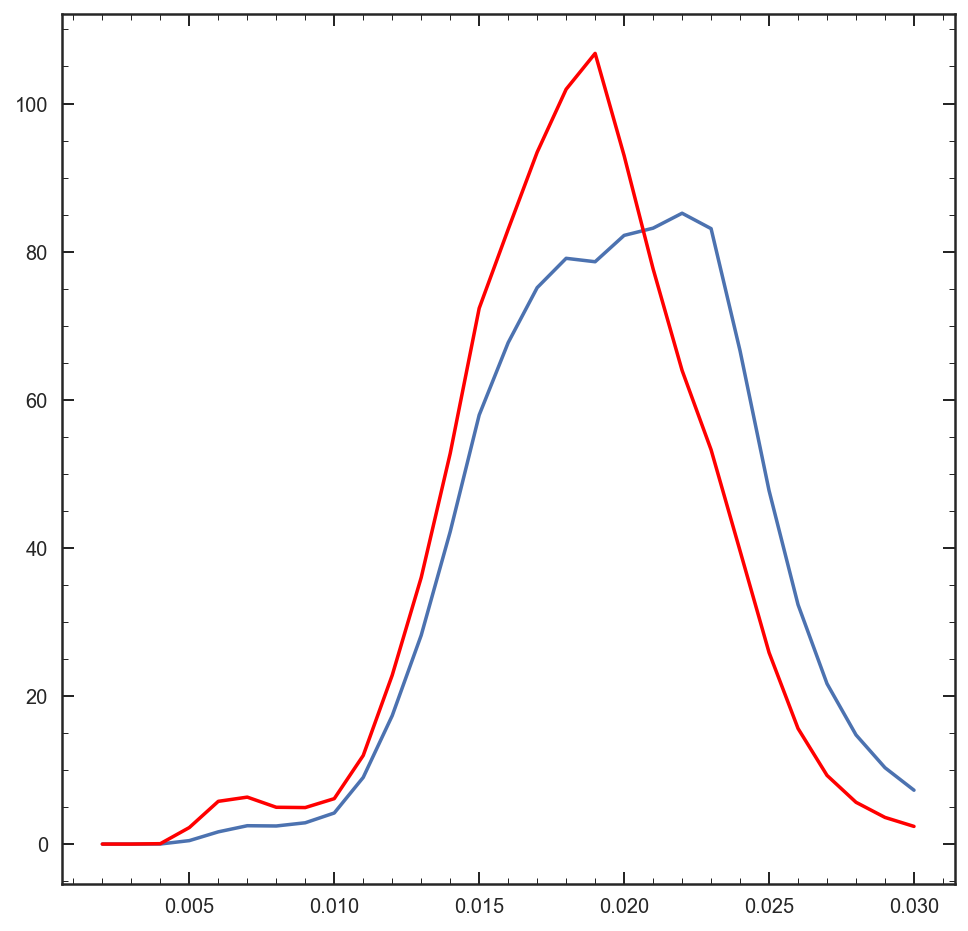

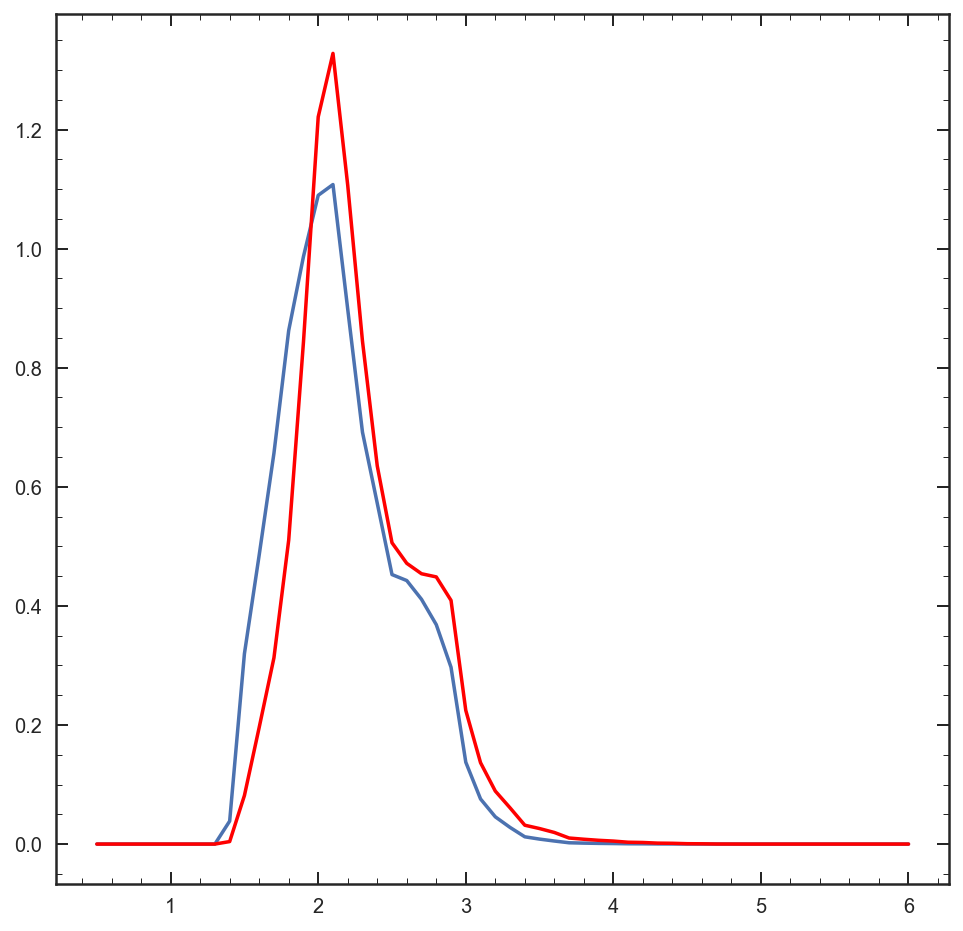

In [32]:
plt.figure(figsize=[8,8])
plt.plot(Z,PZ)
plt.plot(Z,PZ2,'r')   

plt.figure(figsize=[8,8])
plt.plot(t,Pt)
plt.plot(t,Pt2,'r') 

In [33]:
print Median_w_Error(PZ,Z)
print Median_w_Error(PZ2,Z)
print Median_w_Error(Pt,t)
print Median_w_Error(Pt2,t)

(0.02, 0.0049999999999999999999, 0.0039999999999999999998)
(0.019000000000000000001, 0.0039999999999999999998, 0.003)
(2.2, 0.43199999999999999999, 0.405)
(2.2, 0.289, 0.526)
